<a href="https://colab.research.google.com/github/dvellanki/GAN-VAE-AutoEncoder/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 196444503.87it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 89597406.67it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 136284463.73it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17688513.25it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
train_transform = transforms.Compose([
transforms.ToTensor(),
])

In [ ]:
test_transform = transforms.Compose([
transforms.ToTensor(),
])

In [ ]:
train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [ ]:
m=len(train_dataset)

In [ ]:
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

In [ ]:
### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

In [ ]:
#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

In [ ]:
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [ ]:
# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.246767
	 partial train loss (single batch): 0.246560
	 partial train loss (single batch): 0.245986
	 partial train loss (single batch): 0.245857
	 partial train loss (single batch): 0.244895
	 partial train loss (single batch): 0.244557
	 partial train loss (single batch): 0.244828
	 partial train loss (single batch): 0.243619
	 partial train loss (single batch): 0.243363
	 partial train loss (single batch): 0.242152
	 partial train loss (single batch): 0.241817
	 partial train loss (single batch): 0.241802
	 partial train loss (single batch): 0.240025
	 partial train loss (single batch): 0.238899
	 partial train loss (single batch): 0.238685
	 partial train loss (single batch): 0.237099
	 partial train loss (single batch): 0.235696
	 partial train loss (single batch): 0.234748
	 partial train loss (single batch): 0.233229
	 partial train loss (single batch): 0.230930
	 partial train loss (single batch): 0.228480
	 partial train loss (single batch

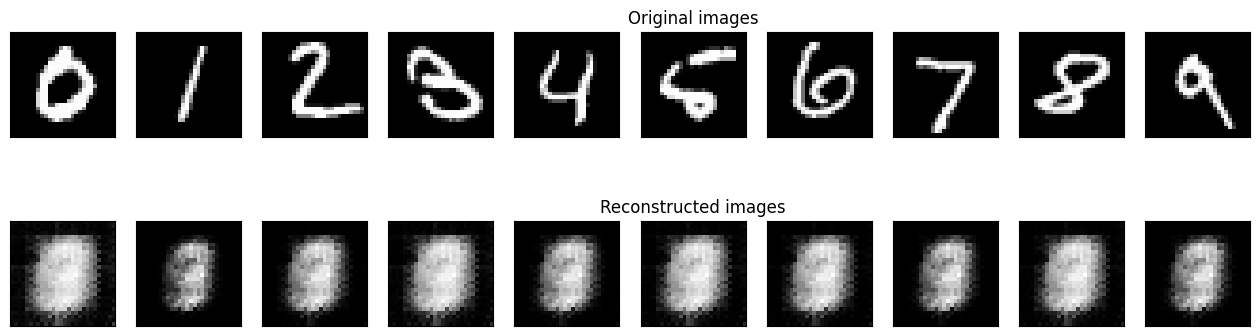

	 partial train loss (single batch): 0.066790
	 partial train loss (single batch): 0.065253
	 partial train loss (single batch): 0.064996
	 partial train loss (single batch): 0.063965
	 partial train loss (single batch): 0.065928
	 partial train loss (single batch): 0.065824
	 partial train loss (single batch): 0.062394
	 partial train loss (single batch): 0.065583
	 partial train loss (single batch): 0.064008
	 partial train loss (single batch): 0.065287
	 partial train loss (single batch): 0.065118
	 partial train loss (single batch): 0.063103
	 partial train loss (single batch): 0.066358
	 partial train loss (single batch): 0.066793
	 partial train loss (single batch): 0.063450
	 partial train loss (single batch): 0.064539
	 partial train loss (single batch): 0.064896
	 partial train loss (single batch): 0.063576
	 partial train loss (single batch): 0.063534
	 partial train loss (single batch): 0.064664
	 partial train loss (single batch): 0.064966
	 partial train loss (single batch

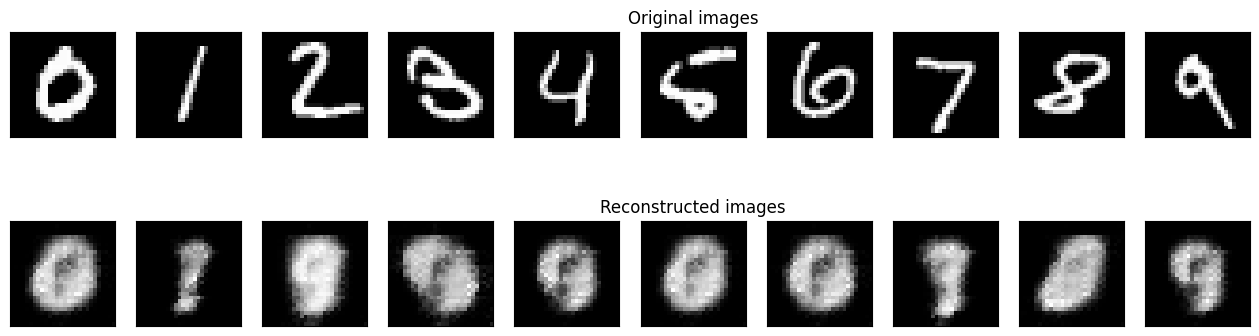

	 partial train loss (single batch): 0.056257
	 partial train loss (single batch): 0.055162
	 partial train loss (single batch): 0.055549
	 partial train loss (single batch): 0.053314
	 partial train loss (single batch): 0.055429
	 partial train loss (single batch): 0.056144
	 partial train loss (single batch): 0.052881
	 partial train loss (single batch): 0.055751
	 partial train loss (single batch): 0.053711
	 partial train loss (single batch): 0.055067
	 partial train loss (single batch): 0.054844
	 partial train loss (single batch): 0.053074
	 partial train loss (single batch): 0.055880
	 partial train loss (single batch): 0.056370
	 partial train loss (single batch): 0.053483
	 partial train loss (single batch): 0.053939
	 partial train loss (single batch): 0.055192
	 partial train loss (single batch): 0.054325
	 partial train loss (single batch): 0.053726
	 partial train loss (single batch): 0.054644
	 partial train loss (single batch): 0.054371
	 partial train loss (single batch

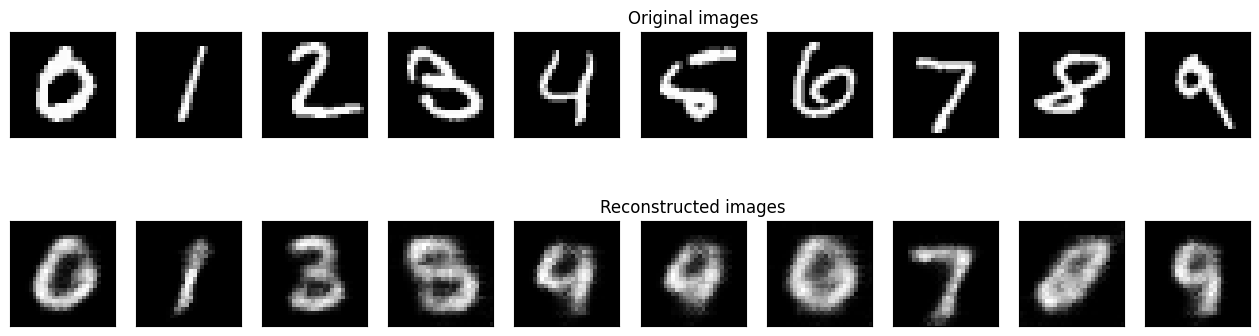

	 partial train loss (single batch): 0.045012
	 partial train loss (single batch): 0.043947
	 partial train loss (single batch): 0.044079
	 partial train loss (single batch): 0.041736
	 partial train loss (single batch): 0.044503
	 partial train loss (single batch): 0.045284
	 partial train loss (single batch): 0.042644
	 partial train loss (single batch): 0.043574
	 partial train loss (single batch): 0.043278
	 partial train loss (single batch): 0.044457
	 partial train loss (single batch): 0.043977
	 partial train loss (single batch): 0.042511
	 partial train loss (single batch): 0.043579
	 partial train loss (single batch): 0.044592
	 partial train loss (single batch): 0.042203
	 partial train loss (single batch): 0.043006
	 partial train loss (single batch): 0.043390
	 partial train loss (single batch): 0.043686
	 partial train loss (single batch): 0.042294
	 partial train loss (single batch): 0.043098
	 partial train loss (single batch): 0.043851
	 partial train loss (single batch

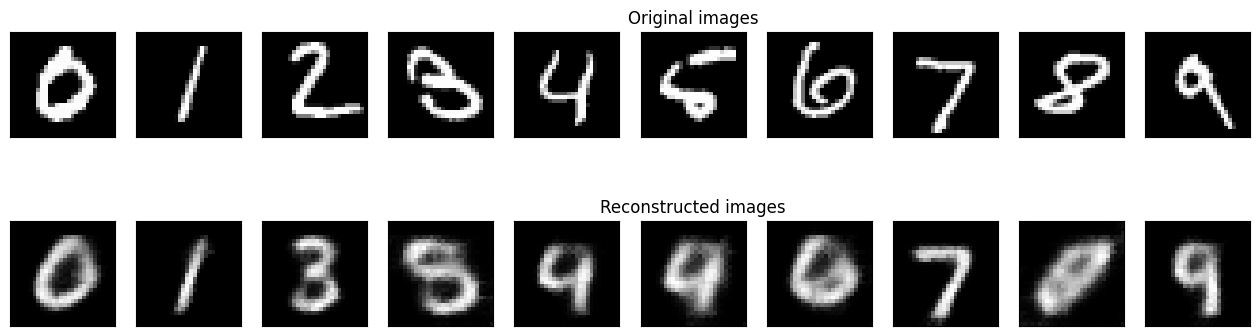

	 partial train loss (single batch): 0.039720
	 partial train loss (single batch): 0.039199
	 partial train loss (single batch): 0.039051
	 partial train loss (single batch): 0.037172
	 partial train loss (single batch): 0.038705
	 partial train loss (single batch): 0.040941
	 partial train loss (single batch): 0.037051
	 partial train loss (single batch): 0.038287
	 partial train loss (single batch): 0.038737
	 partial train loss (single batch): 0.039126
	 partial train loss (single batch): 0.038446
	 partial train loss (single batch): 0.037578
	 partial train loss (single batch): 0.038164
	 partial train loss (single batch): 0.039226
	 partial train loss (single batch): 0.037289
	 partial train loss (single batch): 0.038668
	 partial train loss (single batch): 0.038273
	 partial train loss (single batch): 0.039226
	 partial train loss (single batch): 0.037661
	 partial train loss (single batch): 0.038123
	 partial train loss (single batch): 0.039082
	 partial train loss (single batch

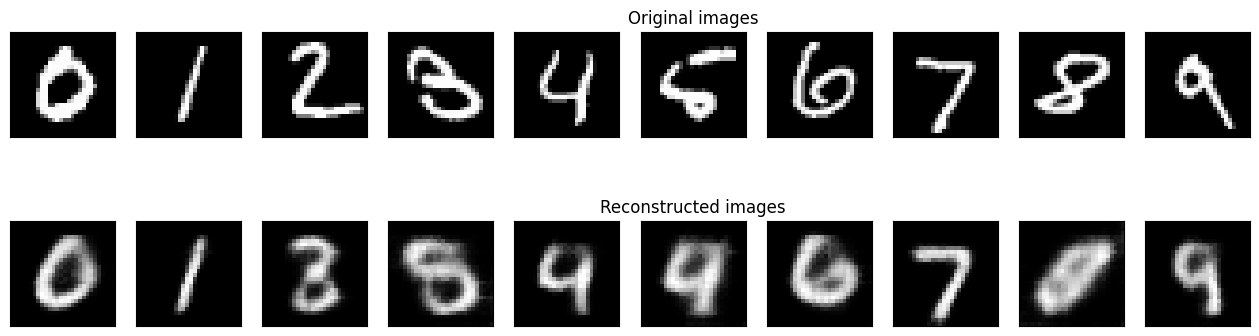

	 partial train loss (single batch): 0.037523
	 partial train loss (single batch): 0.036929
	 partial train loss (single batch): 0.036817
	 partial train loss (single batch): 0.034861
	 partial train loss (single batch): 0.036392
	 partial train loss (single batch): 0.038779
	 partial train loss (single batch): 0.034495
	 partial train loss (single batch): 0.035966
	 partial train loss (single batch): 0.036187
	 partial train loss (single batch): 0.036312
	 partial train loss (single batch): 0.035761
	 partial train loss (single batch): 0.035382
	 partial train loss (single batch): 0.035746
	 partial train loss (single batch): 0.036571
	 partial train loss (single batch): 0.034887
	 partial train loss (single batch): 0.035999
	 partial train loss (single batch): 0.035450
	 partial train loss (single batch): 0.036326
	 partial train loss (single batch): 0.035235
	 partial train loss (single batch): 0.035783
	 partial train loss (single batch): 0.036647
	 partial train loss (single batch

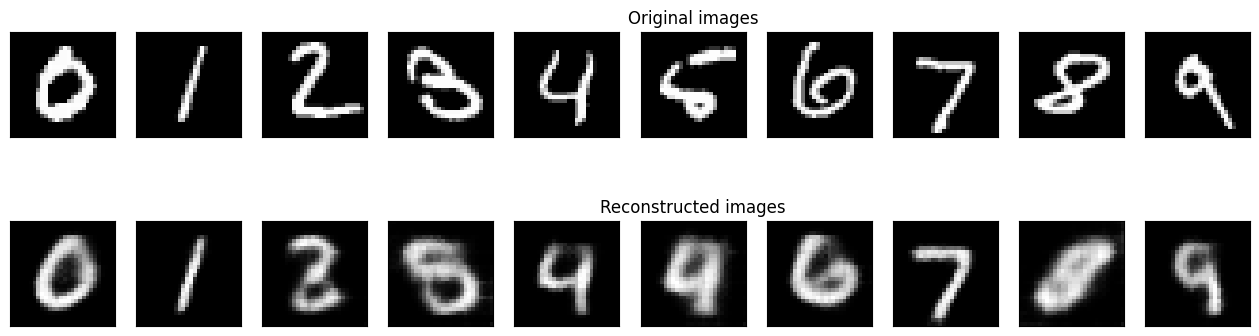

	 partial train loss (single batch): 0.035794
	 partial train loss (single batch): 0.035407
	 partial train loss (single batch): 0.035238
	 partial train loss (single batch): 0.033114
	 partial train loss (single batch): 0.034920
	 partial train loss (single batch): 0.037386
	 partial train loss (single batch): 0.033000
	 partial train loss (single batch): 0.034470
	 partial train loss (single batch): 0.034748
	 partial train loss (single batch): 0.034702
	 partial train loss (single batch): 0.034303
	 partial train loss (single batch): 0.033952
	 partial train loss (single batch): 0.034250
	 partial train loss (single batch): 0.034933
	 partial train loss (single batch): 0.033577
	 partial train loss (single batch): 0.034288
	 partial train loss (single batch): 0.033980
	 partial train loss (single batch): 0.034859
	 partial train loss (single batch): 0.033825
	 partial train loss (single batch): 0.034394
	 partial train loss (single batch): 0.035066
	 partial train loss (single batch

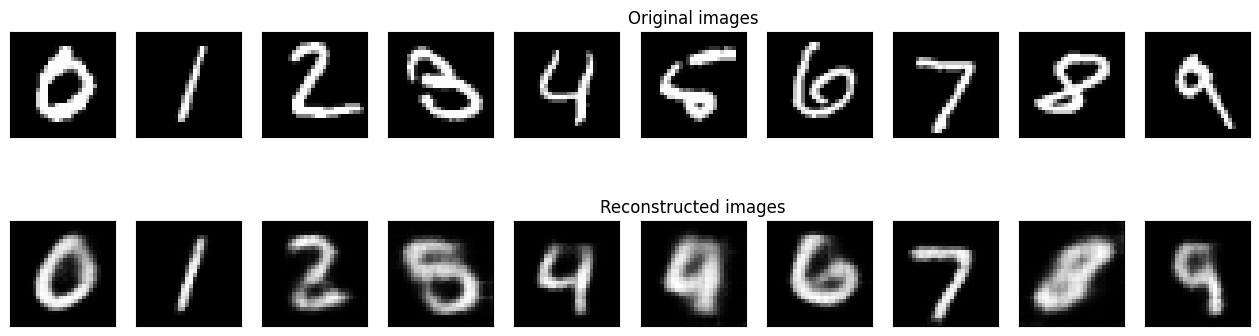

	 partial train loss (single batch): 0.034402
	 partial train loss (single batch): 0.034255
	 partial train loss (single batch): 0.033848
	 partial train loss (single batch): 0.031953
	 partial train loss (single batch): 0.033586
	 partial train loss (single batch): 0.036398
	 partial train loss (single batch): 0.031902
	 partial train loss (single batch): 0.033269
	 partial train loss (single batch): 0.033676
	 partial train loss (single batch): 0.033476
	 partial train loss (single batch): 0.032998
	 partial train loss (single batch): 0.033080
	 partial train loss (single batch): 0.033009
	 partial train loss (single batch): 0.033826
	 partial train loss (single batch): 0.032537
	 partial train loss (single batch): 0.033042
	 partial train loss (single batch): 0.032979
	 partial train loss (single batch): 0.033682
	 partial train loss (single batch): 0.032723
	 partial train loss (single batch): 0.033256
	 partial train loss (single batch): 0.033879
	 partial train loss (single batch

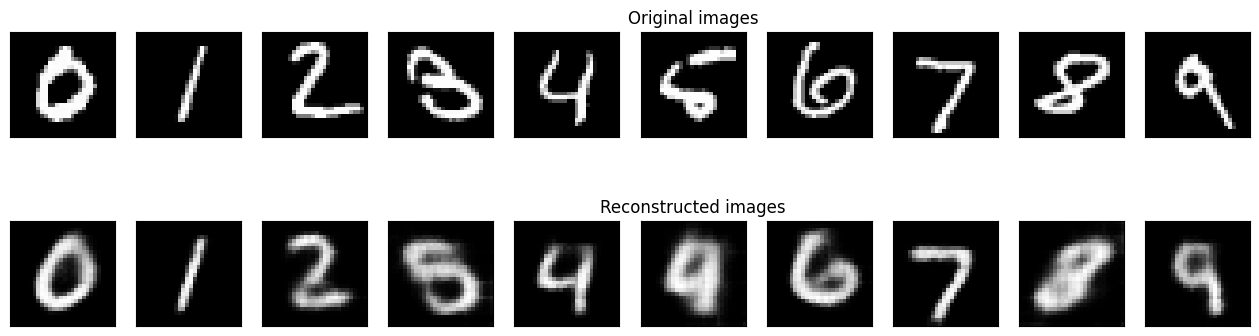

	 partial train loss (single batch): 0.033231
	 partial train loss (single batch): 0.033256
	 partial train loss (single batch): 0.032995
	 partial train loss (single batch): 0.031132
	 partial train loss (single batch): 0.032547
	 partial train loss (single batch): 0.035434
	 partial train loss (single batch): 0.030909
	 partial train loss (single batch): 0.032309
	 partial train loss (single batch): 0.032993
	 partial train loss (single batch): 0.032527
	 partial train loss (single batch): 0.031962
	 partial train loss (single batch): 0.032309
	 partial train loss (single batch): 0.032041
	 partial train loss (single batch): 0.032860
	 partial train loss (single batch): 0.031737
	 partial train loss (single batch): 0.032216
	 partial train loss (single batch): 0.032319
	 partial train loss (single batch): 0.032699
	 partial train loss (single batch): 0.031793
	 partial train loss (single batch): 0.032232
	 partial train loss (single batch): 0.033278
	 partial train loss (single batch

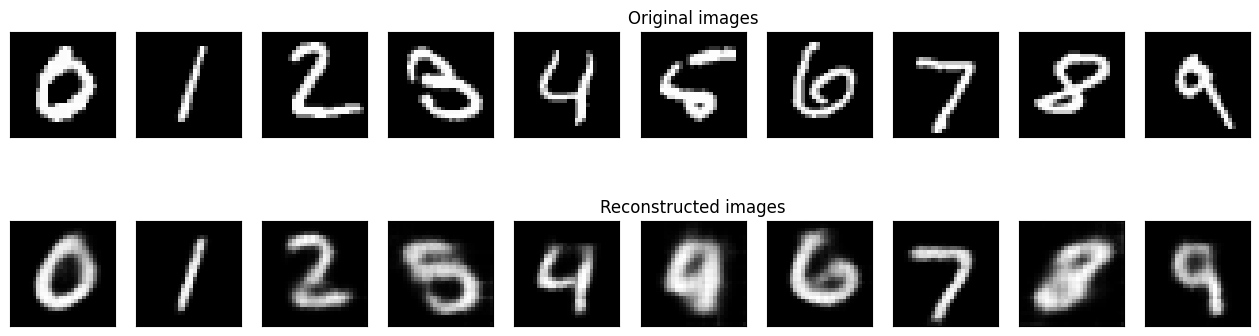

	 partial train loss (single batch): 0.032474
	 partial train loss (single batch): 0.032562
	 partial train loss (single batch): 0.032365
	 partial train loss (single batch): 0.030547
	 partial train loss (single batch): 0.031889
	 partial train loss (single batch): 0.034862
	 partial train loss (single batch): 0.030339
	 partial train loss (single batch): 0.031823
	 partial train loss (single batch): 0.032370
	 partial train loss (single batch): 0.031997
	 partial train loss (single batch): 0.031391
	 partial train loss (single batch): 0.031738
	 partial train loss (single batch): 0.031427
	 partial train loss (single batch): 0.032098
	 partial train loss (single batch): 0.031087
	 partial train loss (single batch): 0.031616
	 partial train loss (single batch): 0.031761
	 partial train loss (single batch): 0.031858
	 partial train loss (single batch): 0.031180
	 partial train loss (single batch): 0.031451
	 partial train loss (single batch): 0.032806
	 partial train loss (single batch

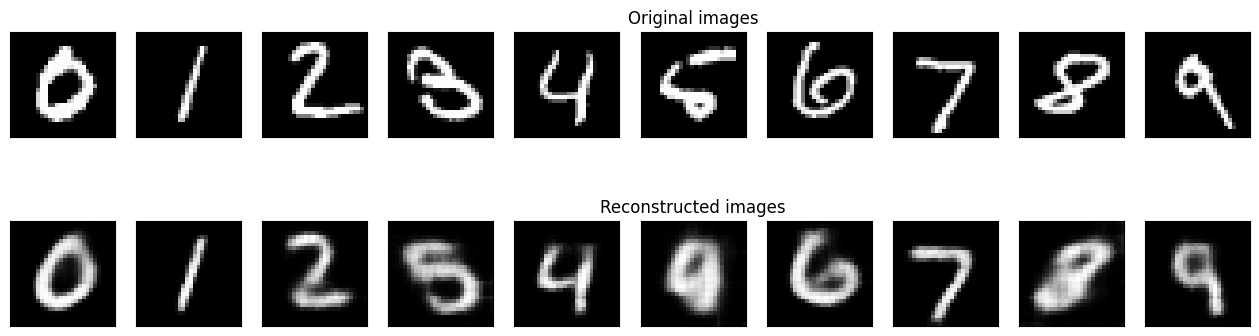

	 partial train loss (single batch): 0.031852
	 partial train loss (single batch): 0.032034
	 partial train loss (single batch): 0.031870
	 partial train loss (single batch): 0.030103
	 partial train loss (single batch): 0.031297
	 partial train loss (single batch): 0.034276
	 partial train loss (single batch): 0.029882
	 partial train loss (single batch): 0.031334
	 partial train loss (single batch): 0.031926
	 partial train loss (single batch): 0.031441
	 partial train loss (single batch): 0.030893
	 partial train loss (single batch): 0.031147
	 partial train loss (single batch): 0.030950
	 partial train loss (single batch): 0.031498
	 partial train loss (single batch): 0.030601
	 partial train loss (single batch): 0.031145
	 partial train loss (single batch): 0.031309
	 partial train loss (single batch): 0.031163
	 partial train loss (single batch): 0.030746
	 partial train loss (single batch): 0.030831
	 partial train loss (single batch): 0.032317
	 partial train loss (single batch

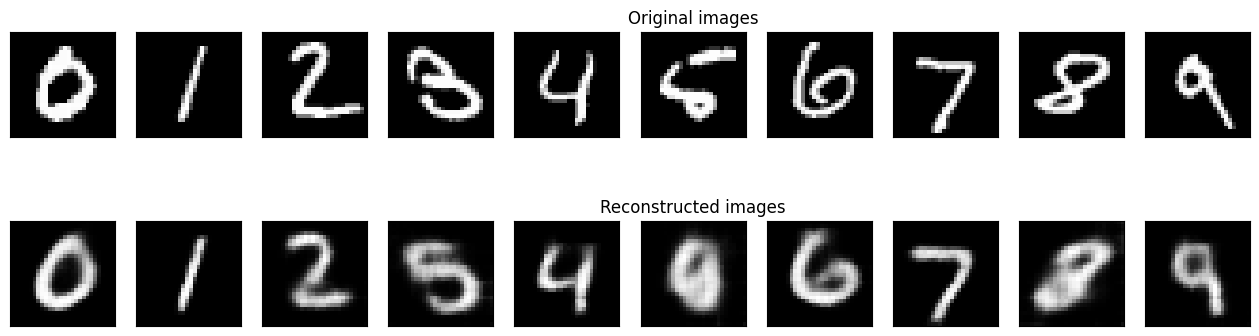

	 partial train loss (single batch): 0.031365
	 partial train loss (single batch): 0.031654
	 partial train loss (single batch): 0.031532
	 partial train loss (single batch): 0.029707
	 partial train loss (single batch): 0.030905
	 partial train loss (single batch): 0.033827
	 partial train loss (single batch): 0.029489
	 partial train loss (single batch): 0.030922
	 partial train loss (single batch): 0.031530
	 partial train loss (single batch): 0.031070
	 partial train loss (single batch): 0.030581
	 partial train loss (single batch): 0.030782
	 partial train loss (single batch): 0.030637
	 partial train loss (single batch): 0.031149
	 partial train loss (single batch): 0.030115
	 partial train loss (single batch): 0.030744
	 partial train loss (single batch): 0.031032
	 partial train loss (single batch): 0.030639
	 partial train loss (single batch): 0.030343
	 partial train loss (single batch): 0.030315
	 partial train loss (single batch): 0.031993
	 partial train loss (single batch

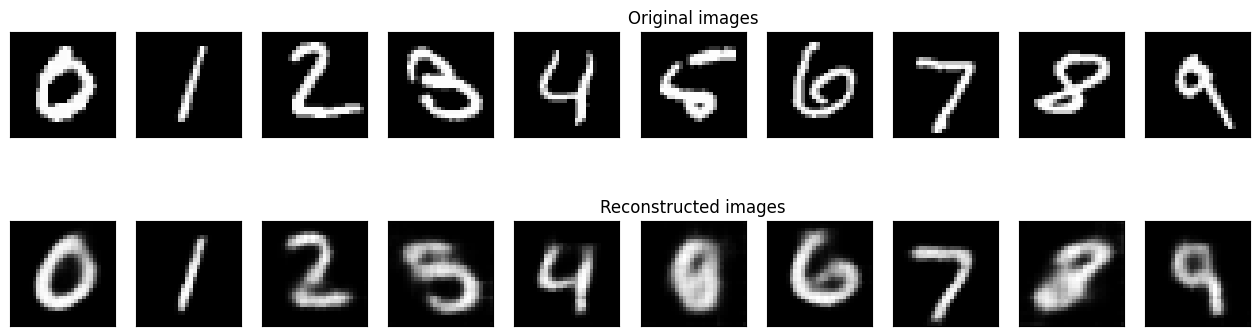

	 partial train loss (single batch): 0.030913
	 partial train loss (single batch): 0.031379
	 partial train loss (single batch): 0.031184
	 partial train loss (single batch): 0.029448
	 partial train loss (single batch): 0.030510
	 partial train loss (single batch): 0.033404
	 partial train loss (single batch): 0.029153
	 partial train loss (single batch): 0.030557
	 partial train loss (single batch): 0.031152
	 partial train loss (single batch): 0.030687
	 partial train loss (single batch): 0.030330
	 partial train loss (single batch): 0.030315
	 partial train loss (single batch): 0.030339
	 partial train loss (single batch): 0.030801
	 partial train loss (single batch): 0.029794
	 partial train loss (single batch): 0.030402
	 partial train loss (single batch): 0.030699
	 partial train loss (single batch): 0.030210
	 partial train loss (single batch): 0.030072
	 partial train loss (single batch): 0.029870
	 partial train loss (single batch): 0.031747
	 partial train loss (single batch

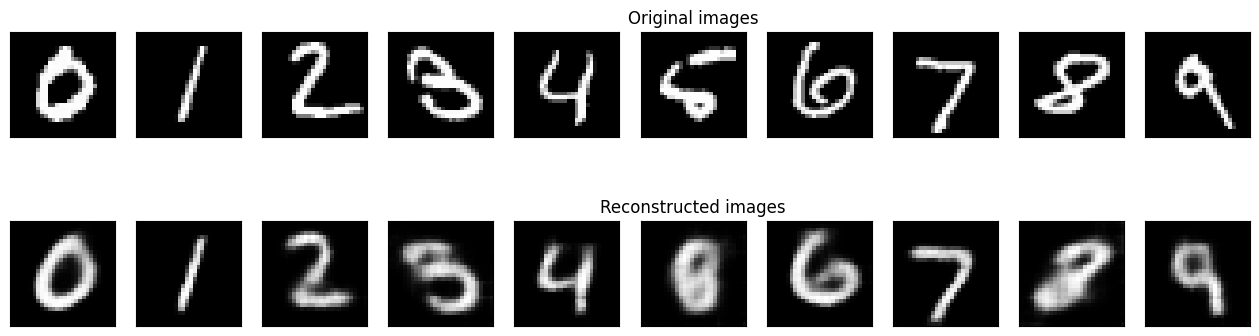

	 partial train loss (single batch): 0.030618
	 partial train loss (single batch): 0.030998
	 partial train loss (single batch): 0.030896
	 partial train loss (single batch): 0.029163
	 partial train loss (single batch): 0.030216
	 partial train loss (single batch): 0.033090
	 partial train loss (single batch): 0.028835
	 partial train loss (single batch): 0.030234
	 partial train loss (single batch): 0.030908
	 partial train loss (single batch): 0.030448
	 partial train loss (single batch): 0.030119
	 partial train loss (single batch): 0.030077
	 partial train loss (single batch): 0.030041
	 partial train loss (single batch): 0.030491
	 partial train loss (single batch): 0.029419
	 partial train loss (single batch): 0.030051
	 partial train loss (single batch): 0.030494
	 partial train loss (single batch): 0.029820
	 partial train loss (single batch): 0.029807
	 partial train loss (single batch): 0.029644
	 partial train loss (single batch): 0.031502
	 partial train loss (single batch

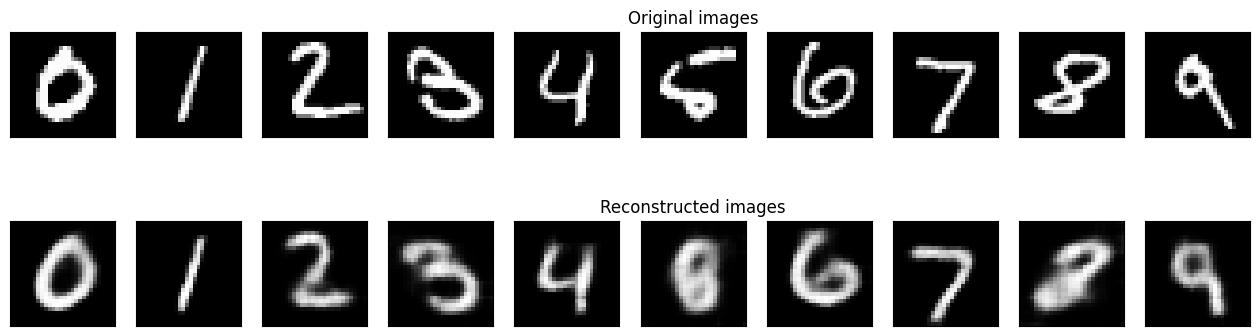

	 partial train loss (single batch): 0.030258
	 partial train loss (single batch): 0.030600
	 partial train loss (single batch): 0.030617
	 partial train loss (single batch): 0.028860
	 partial train loss (single batch): 0.029944
	 partial train loss (single batch): 0.032703
	 partial train loss (single batch): 0.028586
	 partial train loss (single batch): 0.030018
	 partial train loss (single batch): 0.030625
	 partial train loss (single batch): 0.030199
	 partial train loss (single batch): 0.029903
	 partial train loss (single batch): 0.029800
	 partial train loss (single batch): 0.029796
	 partial train loss (single batch): 0.030303
	 partial train loss (single batch): 0.029200
	 partial train loss (single batch): 0.029835
	 partial train loss (single batch): 0.030139
	 partial train loss (single batch): 0.029462
	 partial train loss (single batch): 0.029470
	 partial train loss (single batch): 0.029346
	 partial train loss (single batch): 0.031231
	 partial train loss (single batch

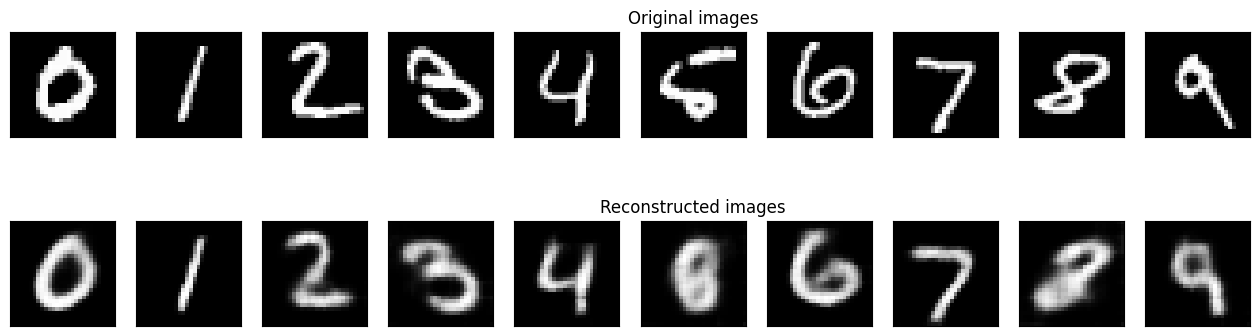

	 partial train loss (single batch): 0.030010
	 partial train loss (single batch): 0.030277
	 partial train loss (single batch): 0.030509
	 partial train loss (single batch): 0.028588
	 partial train loss (single batch): 0.029672
	 partial train loss (single batch): 0.032399
	 partial train loss (single batch): 0.028301
	 partial train loss (single batch): 0.029713
	 partial train loss (single batch): 0.030315
	 partial train loss (single batch): 0.030010
	 partial train loss (single batch): 0.029697
	 partial train loss (single batch): 0.029579
	 partial train loss (single batch): 0.029556
	 partial train loss (single batch): 0.030151
	 partial train loss (single batch): 0.029027
	 partial train loss (single batch): 0.029658
	 partial train loss (single batch): 0.029894
	 partial train loss (single batch): 0.029066
	 partial train loss (single batch): 0.029250
	 partial train loss (single batch): 0.029088
	 partial train loss (single batch): 0.030989
	 partial train loss (single batch

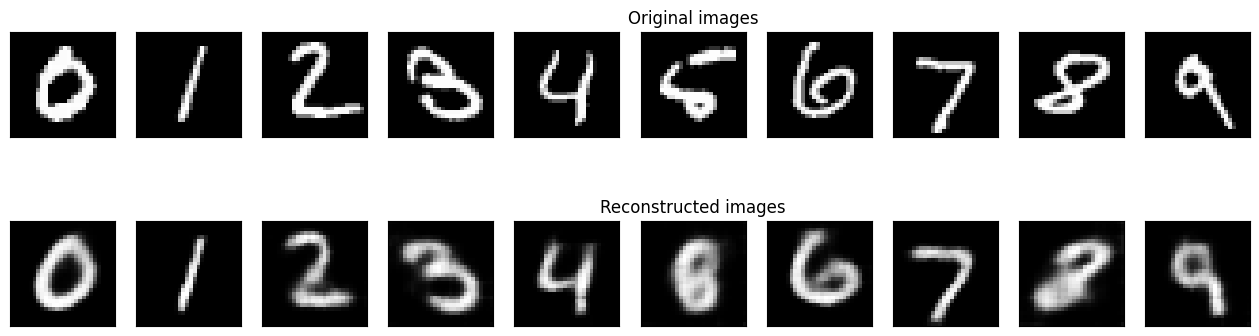

	 partial train loss (single batch): 0.029755
	 partial train loss (single batch): 0.029978
	 partial train loss (single batch): 0.030294
	 partial train loss (single batch): 0.028316
	 partial train loss (single batch): 0.029368
	 partial train loss (single batch): 0.032204
	 partial train loss (single batch): 0.028101
	 partial train loss (single batch): 0.029502
	 partial train loss (single batch): 0.030006
	 partial train loss (single batch): 0.029868
	 partial train loss (single batch): 0.029458
	 partial train loss (single batch): 0.029325
	 partial train loss (single batch): 0.029236
	 partial train loss (single batch): 0.029955
	 partial train loss (single batch): 0.028824
	 partial train loss (single batch): 0.029434
	 partial train loss (single batch): 0.029623
	 partial train loss (single batch): 0.028772
	 partial train loss (single batch): 0.029027
	 partial train loss (single batch): 0.028715
	 partial train loss (single batch): 0.030836
	 partial train loss (single batch

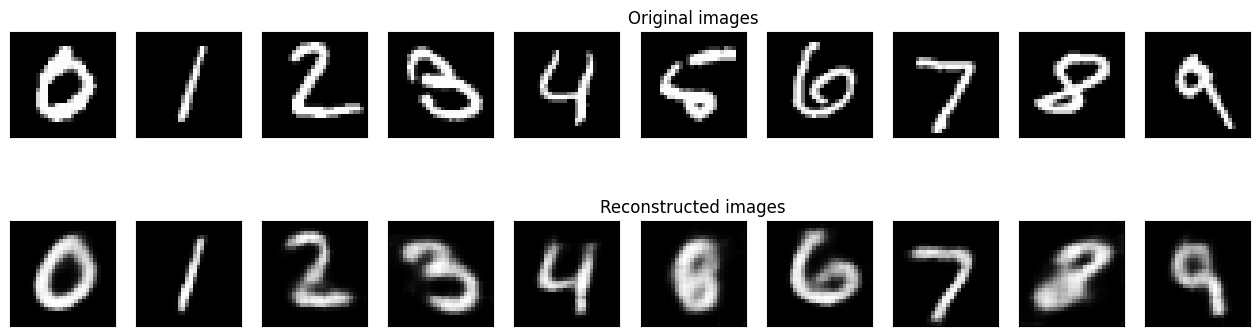

	 partial train loss (single batch): 0.029537
	 partial train loss (single batch): 0.029756
	 partial train loss (single batch): 0.030124
	 partial train loss (single batch): 0.028191
	 partial train loss (single batch): 0.029157
	 partial train loss (single batch): 0.032028
	 partial train loss (single batch): 0.027898
	 partial train loss (single batch): 0.029367
	 partial train loss (single batch): 0.029735
	 partial train loss (single batch): 0.029633
	 partial train loss (single batch): 0.029285
	 partial train loss (single batch): 0.029192
	 partial train loss (single batch): 0.029000
	 partial train loss (single batch): 0.029795
	 partial train loss (single batch): 0.028634
	 partial train loss (single batch): 0.029302
	 partial train loss (single batch): 0.029415
	 partial train loss (single batch): 0.028513
	 partial train loss (single batch): 0.028841
	 partial train loss (single batch): 0.028443
	 partial train loss (single batch): 0.030629
	 partial train loss (single batch

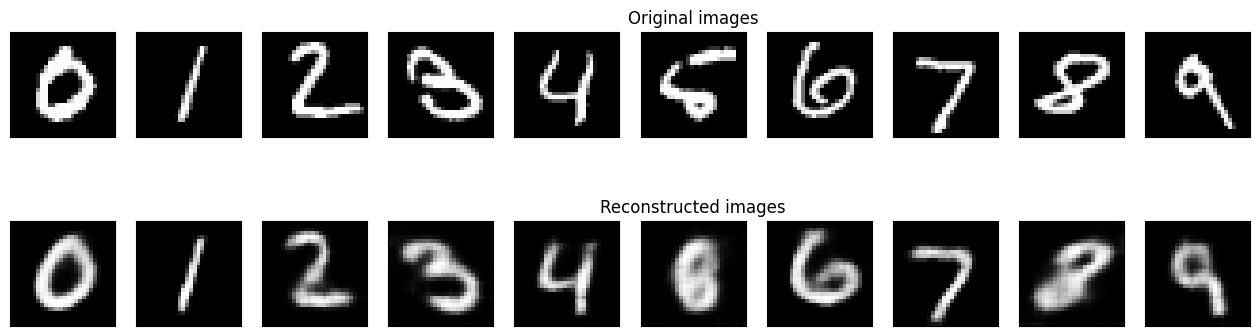

	 partial train loss (single batch): 0.029287
	 partial train loss (single batch): 0.029540
	 partial train loss (single batch): 0.029923
	 partial train loss (single batch): 0.027916
	 partial train loss (single batch): 0.028969
	 partial train loss (single batch): 0.031854
	 partial train loss (single batch): 0.027733
	 partial train loss (single batch): 0.029101
	 partial train loss (single batch): 0.029509
	 partial train loss (single batch): 0.029403
	 partial train loss (single batch): 0.029098
	 partial train loss (single batch): 0.028992
	 partial train loss (single batch): 0.028775
	 partial train loss (single batch): 0.029630
	 partial train loss (single batch): 0.028449
	 partial train loss (single batch): 0.029149
	 partial train loss (single batch): 0.029262
	 partial train loss (single batch): 0.028277
	 partial train loss (single batch): 0.028723
	 partial train loss (single batch): 0.028193
	 partial train loss (single batch): 0.030455
	 partial train loss (single batch

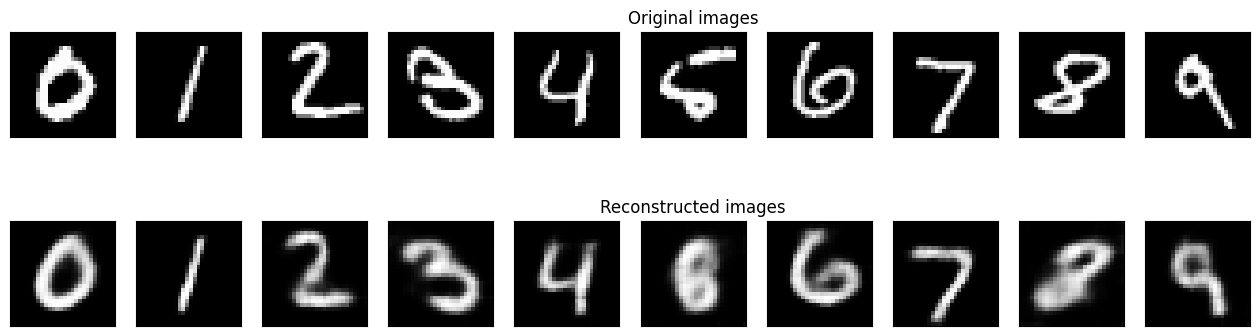

	 partial train loss (single batch): 0.029132
	 partial train loss (single batch): 0.029391
	 partial train loss (single batch): 0.029803
	 partial train loss (single batch): 0.027741
	 partial train loss (single batch): 0.028770
	 partial train loss (single batch): 0.031606
	 partial train loss (single batch): 0.027506
	 partial train loss (single batch): 0.028943
	 partial train loss (single batch): 0.029300
	 partial train loss (single batch): 0.029279
	 partial train loss (single batch): 0.028920
	 partial train loss (single batch): 0.028793
	 partial train loss (single batch): 0.028513
	 partial train loss (single batch): 0.029467
	 partial train loss (single batch): 0.028267
	 partial train loss (single batch): 0.028961
	 partial train loss (single batch): 0.029056
	 partial train loss (single batch): 0.028070
	 partial train loss (single batch): 0.028561
	 partial train loss (single batch): 0.028027
	 partial train loss (single batch): 0.030298
	 partial train loss (single batch

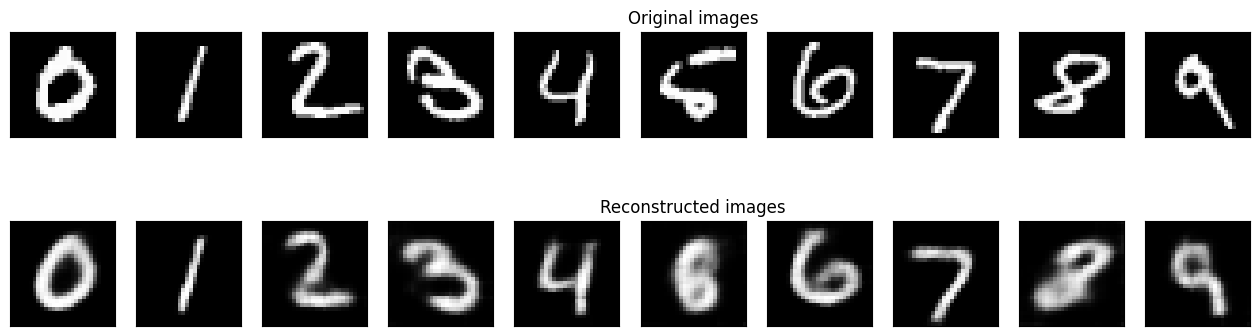

	 partial train loss (single batch): 0.028988
	 partial train loss (single batch): 0.029277
	 partial train loss (single batch): 0.029692
	 partial train loss (single batch): 0.027613
	 partial train loss (single batch): 0.028599
	 partial train loss (single batch): 0.031459
	 partial train loss (single batch): 0.027368
	 partial train loss (single batch): 0.028745
	 partial train loss (single batch): 0.029159
	 partial train loss (single batch): 0.029194
	 partial train loss (single batch): 0.028811
	 partial train loss (single batch): 0.028638
	 partial train loss (single batch): 0.028358
	 partial train loss (single batch): 0.029347
	 partial train loss (single batch): 0.028165
	 partial train loss (single batch): 0.028869
	 partial train loss (single batch): 0.028947
	 partial train loss (single batch): 0.027891
	 partial train loss (single batch): 0.028443
	 partial train loss (single batch): 0.027868
	 partial train loss (single batch): 0.030123
	 partial train loss (single batch

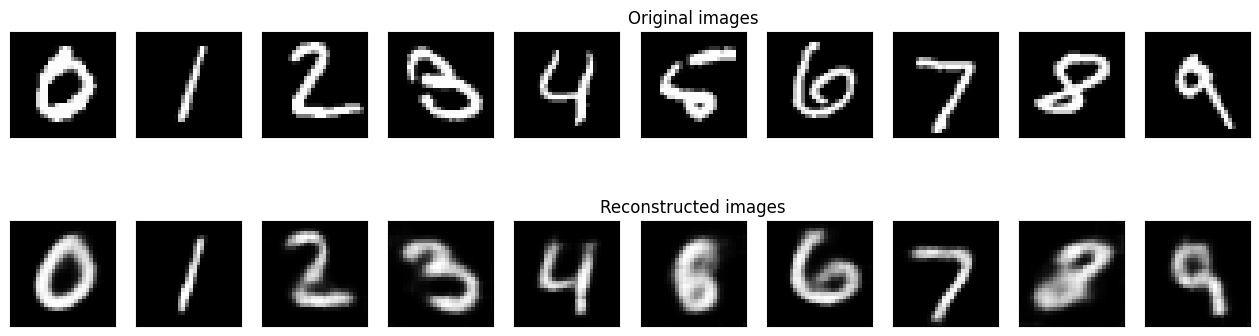

	 partial train loss (single batch): 0.028834
	 partial train loss (single batch): 0.029135
	 partial train loss (single batch): 0.029577
	 partial train loss (single batch): 0.027474
	 partial train loss (single batch): 0.028461
	 partial train loss (single batch): 0.031309
	 partial train loss (single batch): 0.027269
	 partial train loss (single batch): 0.028540
	 partial train loss (single batch): 0.029006
	 partial train loss (single batch): 0.029030
	 partial train loss (single batch): 0.028700
	 partial train loss (single batch): 0.028496
	 partial train loss (single batch): 0.028193
	 partial train loss (single batch): 0.029144
	 partial train loss (single batch): 0.027963
	 partial train loss (single batch): 0.028674
	 partial train loss (single batch): 0.028775
	 partial train loss (single batch): 0.027698
	 partial train loss (single batch): 0.028303
	 partial train loss (single batch): 0.027713
	 partial train loss (single batch): 0.029908
	 partial train loss (single batch

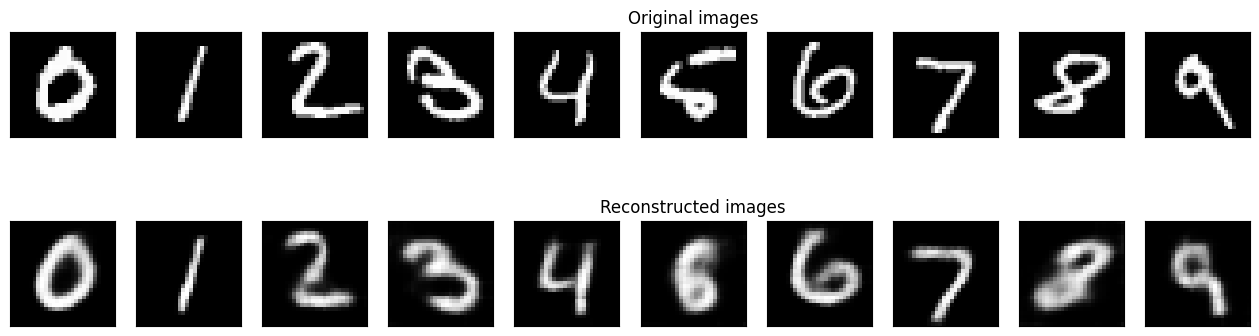

	 partial train loss (single batch): 0.028734
	 partial train loss (single batch): 0.028916
	 partial train loss (single batch): 0.029491
	 partial train loss (single batch): 0.027347
	 partial train loss (single batch): 0.028340
	 partial train loss (single batch): 0.031111
	 partial train loss (single batch): 0.027181
	 partial train loss (single batch): 0.028309
	 partial train loss (single batch): 0.028854
	 partial train loss (single batch): 0.028897
	 partial train loss (single batch): 0.028561
	 partial train loss (single batch): 0.028372
	 partial train loss (single batch): 0.028045
	 partial train loss (single batch): 0.029028
	 partial train loss (single batch): 0.027754
	 partial train loss (single batch): 0.028583
	 partial train loss (single batch): 0.028623
	 partial train loss (single batch): 0.027513
	 partial train loss (single batch): 0.028174
	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.029735
	 partial train loss (single batch

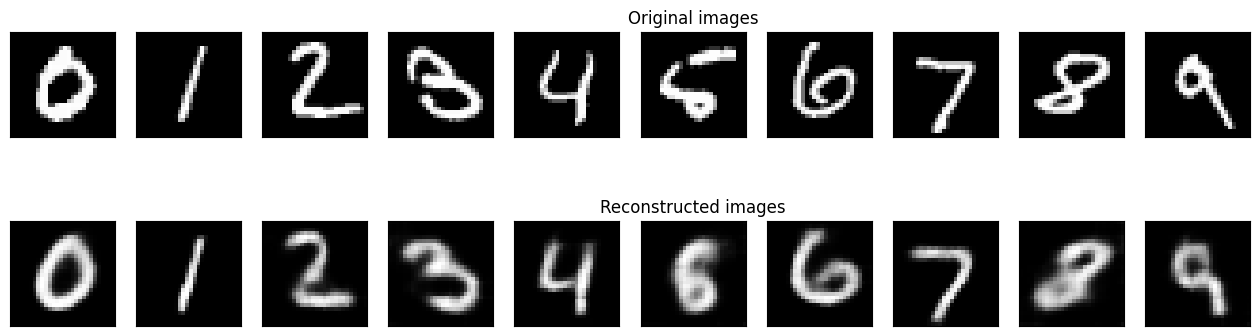

	 partial train loss (single batch): 0.028635
	 partial train loss (single batch): 0.028790
	 partial train loss (single batch): 0.029317
	 partial train loss (single batch): 0.027189
	 partial train loss (single batch): 0.028199
	 partial train loss (single batch): 0.030985
	 partial train loss (single batch): 0.027021
	 partial train loss (single batch): 0.028159
	 partial train loss (single batch): 0.028673
	 partial train loss (single batch): 0.028765
	 partial train loss (single batch): 0.028412
	 partial train loss (single batch): 0.028228
	 partial train loss (single batch): 0.027881
	 partial train loss (single batch): 0.028872
	 partial train loss (single batch): 0.027652
	 partial train loss (single batch): 0.028450
	 partial train loss (single batch): 0.028507
	 partial train loss (single batch): 0.027361
	 partial train loss (single batch): 0.028051
	 partial train loss (single batch): 0.027461
	 partial train loss (single batch): 0.029586
	 partial train loss (single batch

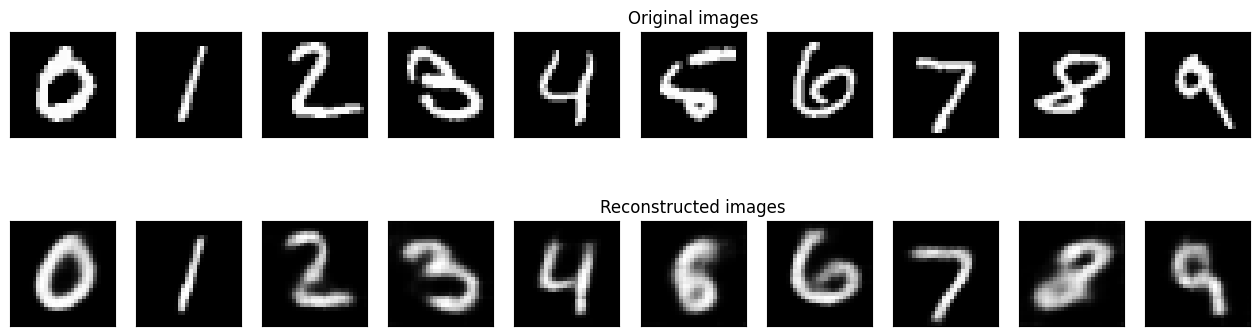

	 partial train loss (single batch): 0.028448
	 partial train loss (single batch): 0.028660
	 partial train loss (single batch): 0.029256
	 partial train loss (single batch): 0.027070
	 partial train loss (single batch): 0.028082
	 partial train loss (single batch): 0.030842
	 partial train loss (single batch): 0.026918
	 partial train loss (single batch): 0.028105
	 partial train loss (single batch): 0.028527
	 partial train loss (single batch): 0.028648
	 partial train loss (single batch): 0.028358
	 partial train loss (single batch): 0.028069
	 partial train loss (single batch): 0.027798
	 partial train loss (single batch): 0.028792
	 partial train loss (single batch): 0.027506
	 partial train loss (single batch): 0.028348
	 partial train loss (single batch): 0.028361
	 partial train loss (single batch): 0.027216
	 partial train loss (single batch): 0.027962
	 partial train loss (single batch): 0.027362
	 partial train loss (single batch): 0.029491
	 partial train loss (single batch

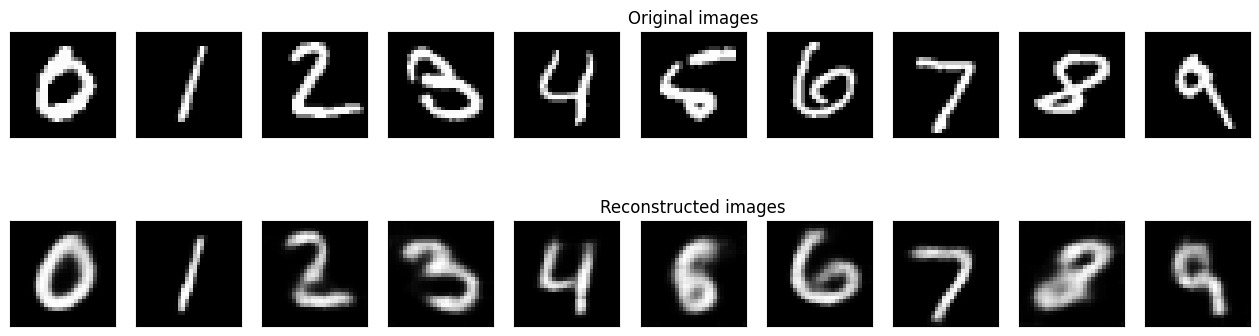

	 partial train loss (single batch): 0.028405
	 partial train loss (single batch): 0.028567
	 partial train loss (single batch): 0.029133
	 partial train loss (single batch): 0.026987
	 partial train loss (single batch): 0.028030
	 partial train loss (single batch): 0.030770
	 partial train loss (single batch): 0.026878
	 partial train loss (single batch): 0.027970
	 partial train loss (single batch): 0.028438
	 partial train loss (single batch): 0.028598
	 partial train loss (single batch): 0.028327
	 partial train loss (single batch): 0.027920
	 partial train loss (single batch): 0.027711
	 partial train loss (single batch): 0.028669
	 partial train loss (single batch): 0.027397
	 partial train loss (single batch): 0.028251
	 partial train loss (single batch): 0.028246
	 partial train loss (single batch): 0.027127
	 partial train loss (single batch): 0.027854
	 partial train loss (single batch): 0.027255
	 partial train loss (single batch): 0.029346
	 partial train loss (single batch

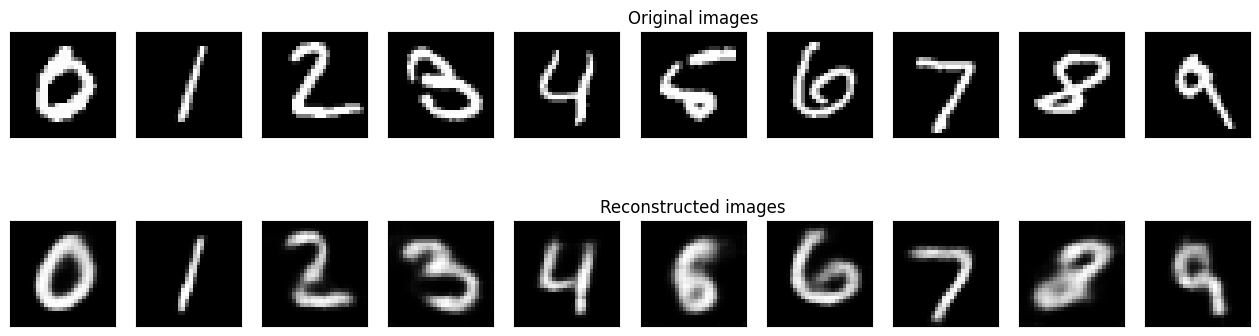

	 partial train loss (single batch): 0.028289
	 partial train loss (single batch): 0.028436
	 partial train loss (single batch): 0.029082
	 partial train loss (single batch): 0.026880
	 partial train loss (single batch): 0.027904
	 partial train loss (single batch): 0.030627
	 partial train loss (single batch): 0.026793
	 partial train loss (single batch): 0.027907
	 partial train loss (single batch): 0.028278
	 partial train loss (single batch): 0.028463
	 partial train loss (single batch): 0.028226
	 partial train loss (single batch): 0.027803
	 partial train loss (single batch): 0.027593
	 partial train loss (single batch): 0.028557
	 partial train loss (single batch): 0.027272
	 partial train loss (single batch): 0.028110
	 partial train loss (single batch): 0.028099
	 partial train loss (single batch): 0.027005
	 partial train loss (single batch): 0.027675
	 partial train loss (single batch): 0.027144
	 partial train loss (single batch): 0.029293
	 partial train loss (single batch

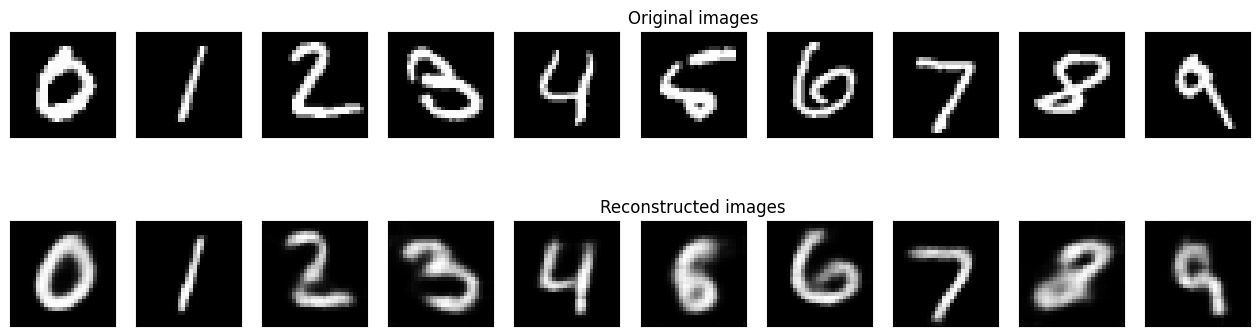

	 partial train loss (single batch): 0.028170
	 partial train loss (single batch): 0.028350
	 partial train loss (single batch): 0.028969
	 partial train loss (single batch): 0.026850
	 partial train loss (single batch): 0.027823
	 partial train loss (single batch): 0.030537
	 partial train loss (single batch): 0.026722
	 partial train loss (single batch): 0.027865
	 partial train loss (single batch): 0.028200
	 partial train loss (single batch): 0.028358
	 partial train loss (single batch): 0.028220
	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.027491
	 partial train loss (single batch): 0.028452
	 partial train loss (single batch): 0.027110
	 partial train loss (single batch): 0.027981
	 partial train loss (single batch): 0.027997
	 partial train loss (single batch): 0.026918
	 partial train loss (single batch): 0.027570
	 partial train loss (single batch): 0.027098
	 partial train loss (single batch): 0.029208
	 partial train loss (single batch

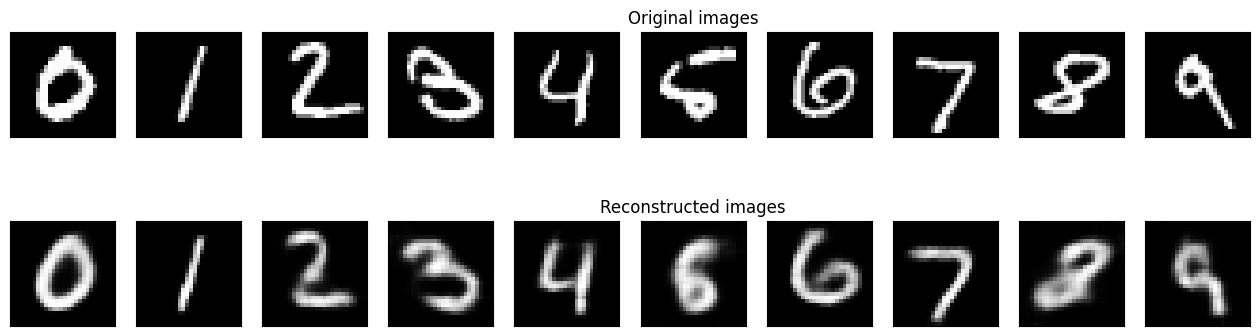

	 partial train loss (single batch): 0.028140
	 partial train loss (single batch): 0.028283
	 partial train loss (single batch): 0.028903
	 partial train loss (single batch): 0.026828
	 partial train loss (single batch): 0.027728
	 partial train loss (single batch): 0.030465
	 partial train loss (single batch): 0.026672
	 partial train loss (single batch): 0.027792
	 partial train loss (single batch): 0.028127
	 partial train loss (single batch): 0.028293
	 partial train loss (single batch): 0.028142
	 partial train loss (single batch): 0.027585
	 partial train loss (single batch): 0.027419
	 partial train loss (single batch): 0.028380
	 partial train loss (single batch): 0.027034
	 partial train loss (single batch): 0.027918
	 partial train loss (single batch): 0.027920
	 partial train loss (single batch): 0.026823
	 partial train loss (single batch): 0.027470
	 partial train loss (single batch): 0.027005
	 partial train loss (single batch): 0.029150
	 partial train loss (single batch

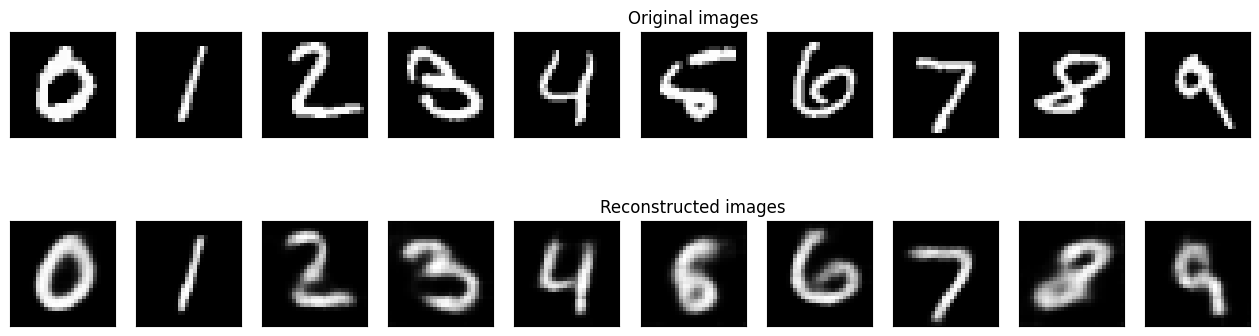

	 partial train loss (single batch): 0.028079
	 partial train loss (single batch): 0.028167
	 partial train loss (single batch): 0.028884
	 partial train loss (single batch): 0.026809
	 partial train loss (single batch): 0.027633
	 partial train loss (single batch): 0.030349
	 partial train loss (single batch): 0.026590
	 partial train loss (single batch): 0.027722
	 partial train loss (single batch): 0.027962
	 partial train loss (single batch): 0.028214
	 partial train loss (single batch): 0.028032
	 partial train loss (single batch): 0.027545
	 partial train loss (single batch): 0.027331
	 partial train loss (single batch): 0.028231
	 partial train loss (single batch): 0.026930
	 partial train loss (single batch): 0.027755
	 partial train loss (single batch): 0.027827
	 partial train loss (single batch): 0.026723
	 partial train loss (single batch): 0.027415
	 partial train loss (single batch): 0.026905
	 partial train loss (single batch): 0.029072
	 partial train loss (single batch

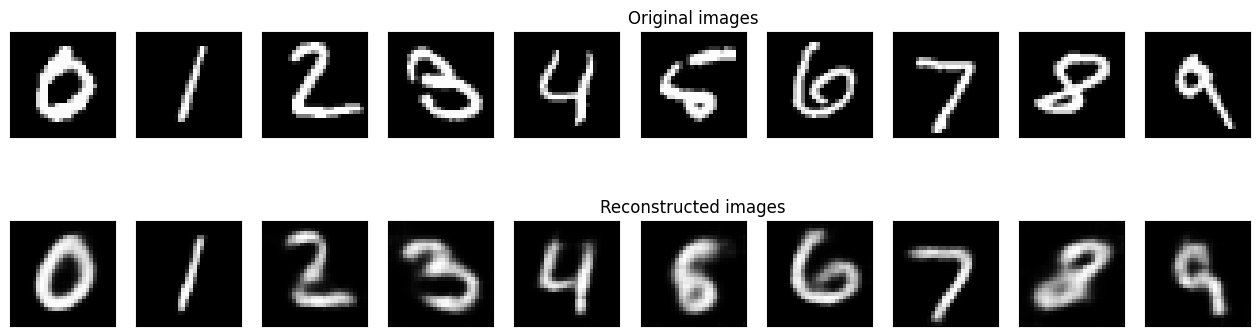

In [ ]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [ ]:
print(m)

60000


In [ ]:
len(test_dataset)

10000

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02806822396814823

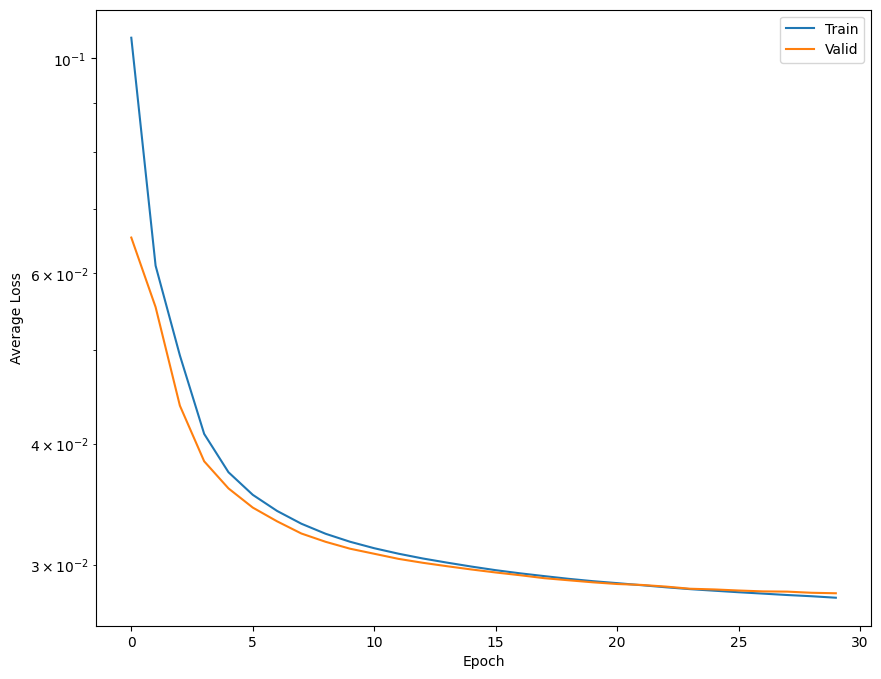

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([ 1.5148,  4.1936, -2.5539, -5.7844])
tensor([9.7007, 8.6223, 7.0350, 7.4687])


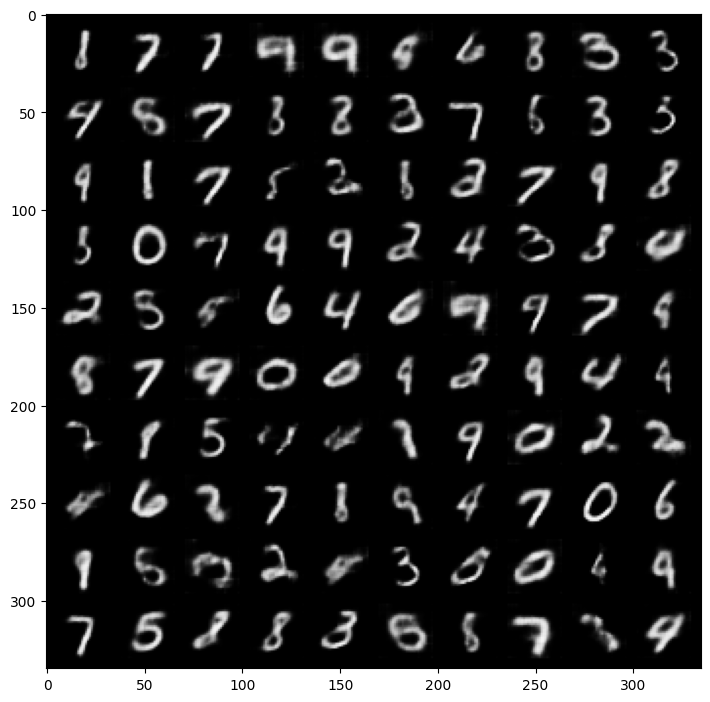

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [ ]:
#!pip3 install tqdm
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 10000/10000 [00:08<00:00, 1118.05it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,17.803562,11.403552,-4.563955,9.307753,7
1,-11.329302,11.176024,-0.374272,0.480114,2
2,2.939015,24.306135,-25.228373,-2.698747,1
3,-4.126147,-8.165830,5.526700,-13.399083,0
4,21.000490,3.373098,6.182885,-15.768911,4
...,...,...,...,...,...
9995,-3.100929,4.404366,-2.261781,0.649060,2
9996,-12.917319,3.008387,2.082355,-3.529673,3
9997,10.955548,2.932913,-5.860887,-4.210907,4
9998,-1.532852,-4.084152,-10.841262,-5.179035,5


In [ ]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()